**Importing Libaries**

In [2]:
!pip install datasets
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = load_dataset("flaviagiammarino/path-vqa")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

# New Section

**Build Model**

In [3]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

**Model Training**

In [4]:
train_data = dataset['train'].select(range(10000))
val_data = dataset['validation'].select(range(1000))
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=train_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor

                            )
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()
for epoch in range(3):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Epoch: 0


  0%|          | 0/157 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 595.9391539096832
Epoch: 1


  0%|          | 0/157 [00:00<?, ?it/s]

Loss: 258.17692744731903
Epoch: 2


  0%|          | 0/157 [00:00<?, ?it/s]

Loss: 249.96367144584656
Epoch: 3


  0%|          | 0/157 [00:00<?, ?it/s]

Loss: 243.58704125881195
Epoch: 4


  0%|          | 0/157 [00:00<?, ?it/s]

Loss: 239.26055109500885


**Inference**

Question:  where are liver stem cells ( oval cells ) located?
Predicted Answer:  in the center of the field
Actual Answer:  in the canals of hering


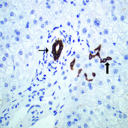

###################################################################
Question:  what are stained here with an immunohistochemical stain for cytokeratin 7?
Predicted Answer:  the wedge shaped cap
Actual Answer:  bile duct cells and canals of hering


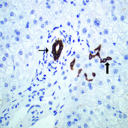

###################################################################
Question:  what do the areas of white chalky deposits represent?
Predicted Answer:  the wedge shaped shaped yellow section
Actual Answer:  foci of fat necrosis


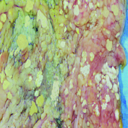

###################################################################
Question:  is embolus derived from a lower - extremity deep venous thrombus lodged in a pulmonary artery branch?
Predicted Answer:  no
Actual Answer:  yes


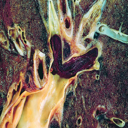

###################################################################
Question:  how is hyperplasia without atypia characterized?
Predicted Answer:  by streptococci
Actual Answer:  by nests of closely packed glands


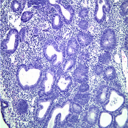

###################################################################


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std
for x in range(5):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")